### Segmentation of coronal holes

In this Notebook we will restore the neural network model and run segmentation of coronal holes in SDO/AIA image.

Start with general imports.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

sys.path.append("..")

%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


Restore saved model.

In [2]:
from src import u_net, conv_block

PATH_TO_SAVED_MODEL = "../model_dumps/ch_seg_model.ckpt"

image_shape = (256, 256, 1)
mask_shape = (256, 256, 1)

unet_depth = 4 #Depth of u-net network
unet_init_filters = 24 #Number of filters int the first conv layer

config = tf.ConfigProto()
graph = tf.Graph()
with graph.as_default():
    images = tf.placeholder('float', shape=(None, ) + image_shape, name='images')
    masks = tf.placeholder('float', shape=(None, ) + mask_shape, name='masks')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    res = u_net(images, unet_depth, unet_init_filters, is_training=is_training)

    logits = conv_block(res, 'c', mask_shape[-1])    
    predict = tf.nn.sigmoid(logits)
    print('output', predict.get_shape())
    
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, PATH_TO_SAVED_MODEL)

input (?, 256, 256, 1)
conv_block_0 (?, 256, 256, 24)
pool_0 (?, 128, 128, 24)
conv_block_1 (?, 128, 128, 48)
pool_1 (?, 64, 64, 48)
conv_block_2 (?, 64, 64, 96)
pool_2 (?, 32, 32, 96)
conv_block_3 (?, 32, 32, 192)
pool_3 (?, 16, 16, 192)
bottom_conv_block_4 (?, 16, 16, 384)
up_3 (?, 32, 32, 384)
concat_4 (?, 32, 32, 576)
up_conv_block_4 (?, 32, 32, 192)
up_2 (?, 64, 64, 192)
concat_3 (?, 64, 64, 288)
up_conv_block_3 (?, 64, 64, 96)
up_1 (?, 128, 128, 96)
concat_2 (?, 128, 128, 144)
up_conv_block_2 (?, 128, 128, 48)
up_0 (?, 256, 256, 48)
concat_1 (?, 256, 256, 72)
up_conv_block_1 (?, 256, 256, 24)
output (?, 256, 256, 1)
INFO:tensorflow:Restoring parameters from ../model_dumps/ch_seg_model.ckpt


Set path to image or images you want to process.

In [3]:
from src import FileIndexer, ImageBatch, BatchGenerator

index = FileIndexer([{'name': 'images', 'path': '../l0193.jpg'}]) #Set correct path

bg = BatchGenerator(index, ImageBatch)

Check the preprocessing pipeline.

In [4]:
def preprocess(batch):
    return (batch.load_images(fmt='jpeg') #Load from jpeg format
            .downsize_image(['images'], 256) #Downsize images to 256 x 256
            .apply(lambda x: x / 255, ['images']) #Change pixel intensity range to [0, 1]
           )

Run the model. Note that here we feed all images at once. If you want to process a lot of images, we suggest to iterate over the dataset with small batches to avoid memory exhaustion.

In [5]:
next_batch = bg.next_batch(len(bg), n_epochs=None, shuffle=False, drop_last=False)   
batch = preprocess(next_batch)
x = np.array([i for i in batch.images])
out = sess.run(predict, feed_dict={images: x, is_training: False})

Plot isolated coronal holes.

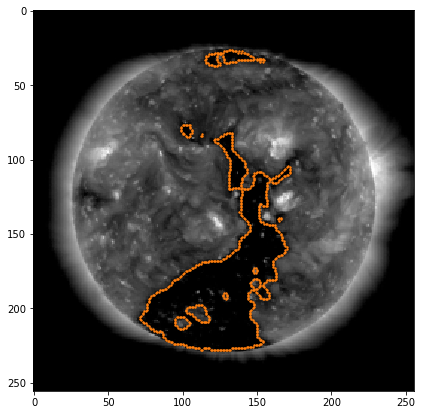

In [6]:
from src import detect_edges
%matplotlib inline

fsize = 7
fig = plt.figure(figsize=(fsize, fsize))
plt.imshow(x[0][:, :, 0], cmap='gray')
ed = np.where(detect_edges(np.rint(out[0][:, :, 0])) == 1)
plt.scatter(ed[1], ed[0], s=2, color="#ff7f0e")
plt.show()

Done!